# Selection criterion size convex hull pt.I: Merged clusters
# Convex hull as diagnostic tool in single-molecule localization microscopy

In [1]:
import numpy as np
import pandas as pd
import py_files.selection_criterion_merge as scmerge
import py_files.convex_hull as ch
import py_files.simulations as si
from py_files.matplotlib_custom import second_axis_log, second_axis

import colorcet as cc
import boost_histogram as bh
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

## Load lookup table of area convex hull
Contains mean, standard deviation of areas of the convex hull, can be scaled with certain factors

In [2]:
lookup_table = pd.read_csv(r"Lookup_tables\lookup_table_area_2d.csv", index_col=0)
mean = lookup_table.loc["$E(A_{ch}(n))$"].astype(float).values
std_pos = lookup_table.loc["$std_{pos}(n)$"].astype(float).values

Scale the values of the lookup table to the desired localization precision of the data simulation. In the case of the area, it is localization precision squared.

In [3]:
cluster_std = 8
max_areas_1sigma = (mean + std_pos)*cluster_std**2
max_areas_2sigma = (mean + 2*std_pos)*cluster_std**2
max_areas_3sigma = (mean + 3*std_pos)*cluster_std**2
max_areas_4sigma = (mean + 4*std_pos)*cluster_std**2
max_areas_5sigma = (mean + 5*std_pos)*cluster_std**2

## Table of different measures to evaluate the method using different threshold levels
Data is simulated, clustered and analyzed. The clusters areas that exceed the applied threshold are the target of this method. They can be filtered out or stored elsewhere. 
### Note: the threshold only applies to clusters that consist up to 200 samples. All clusters that exceed this value are targeted by the method no matter their area. 
This can (and should be) done since the clustersize n is drawn from a geometric distribution with mean ~9. The chance of a cluster to take the value >200 is $1-(1-(1-\frac{1}{10})^{201}) = 6.3*10^{-10}$.

In [4]:
parent_intensities = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 10e-5, 15e-5, 20e-5]
limits_ = si.limits(parent_intensities, 15e-5, 5000)
sim_param = dict(cluster_mu=9, cluster_std=8, min_samples=3, seed=np.random.default_rng(100))
alg_param = dict(eps=25, min_samples=3)
n_simulations = 30
max_areas = [max_areas_1sigma, max_areas_2sigma, max_areas_3sigma, max_areas_4sigma, max_areas_5sigma]
max_areas_keys = ["1 sigma", "2 sigma", "3 sigma", "4 sigma", "5 sigma"]
sca_means, sca_stds, sca_representation = scmerge.selection_criterion_analysis(n_simulations, parent_intensities, 
                                                                               limits_, sim_param, alg_param, 
                                                                               max_areas, max_areas_keys)
sca_representation.to_csv("Selection_criterion_data\sca_means_stds.csv")
sca_means.to_csv("Selection_criterion_data\sca_means.csv")
sca_stds.to_csv("Selection_criterion_data\sca_stds.csv")

## The portion of merged clusters of the algorithm per cluster density

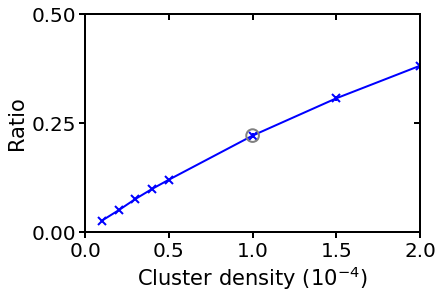

In [5]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = sca_means.index.levels[0]
x2 = x[5]
y = sca_means.loc[(slice(None), sca_means.index.levels[1][0]), "Algorithm merged clusters"].values
y2 = y[5]
yerr = sca_stds.loc[(slice(None), sca_stds.index.levels[1][0]), "Algorithm merged clusters"].values
ax.errorbar(x, y, yerr=yerr, lw=2, color="blue", zorder=1, marker="x", ms=8, mew=2, ecolor="blue")
ax.scatter(x2, y2, marker="o", color="grey", s=160, zorder=2, lw=2, facecolors="none")
ax.set_ylim(0, 0.5)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("Ratio", fontsize=21)
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlim(0, 20e-5)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.25
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.xaxis.get_offset_text().set_visible(False)
fig.savefig(r"Figures\Figure 3\merge_per_density.svg")

## The portion of true and false positives with selection by convex hull

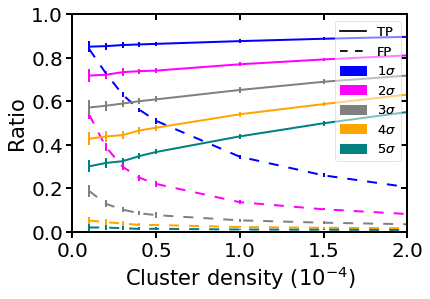

In [6]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = sca_means.index.levels[0]
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, threshold in enumerate(sca_means.index.levels[1]):
    tp = sca_means.loc[(slice(None), threshold), "True positives"].values
    tp_yerr = sca_stds.loc[(slice(None), threshold), "True positives"].values
    fp = sca_means.loc[(slice(None), threshold), "False positives"].values
    fp_yerr = sca_stds.loc[(slice(None), threshold), "False positives"].values
    ax.errorbar(x, tp, yerr=tp_yerr, label=threshold, c=color[i], lw=2, marker="", markeredgewidth=2)
    ax.errorbar(x, fp, yerr=fp_yerr, ls=(0, (5, 5)), label=threshold, c=color[i], lw=2, marker="", 
                markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=str(i+1) + r"$\sigma$")

handles_legend = [mlines.Line2D([], [], label="TP", c="k", marker=""), 
                  mlines.Line2D([], [], label="FP", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(0, 20e-5)
fig.savefig(r"Figures\Figure 3\TP_FP_method.svg")

## The portion of true and false positives with selection by n

In [7]:
n_simulations = 30
parent_intensities = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 10e-5, 15e-5, 20e-5]
limits_ = si.limits(parent_intensities, 15e-5, 5000)
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(cluster_mu=9, cluster_std=8, min_samples=3, seed=np.random.default_rng(100))
max_sample_counts = [10, 15, 20, 25, 30]
sample_count_means, sample_count_stds = scmerge.selection_by_sample_count(n_simulations, parent_intensities, limits_, 
                                                                          sim_param, alg_param, max_sample_counts)
np.save(file=r"Selection_criterion_data\sample_count_means.npy", arr=sample_count_means)
np.save(file=r"Selection_criterion_data\sample_count_stds.npy", arr=sample_count_stds)

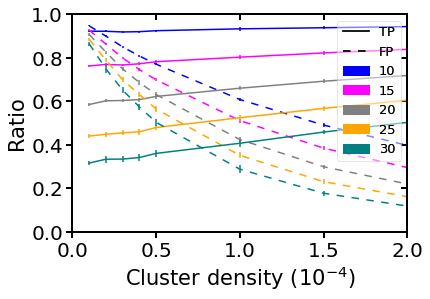

In [8]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = parent_intensities
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, max_sample_count in enumerate(max_sample_counts):
    fp = sample_count_means[:, i, 0]
    fp_yerr = sample_count_stds[:, i, 0]
    tp = sample_count_means[:, i, 1]
    tp_yerr = sample_count_stds[:, i, 0]
    ax.errorbar(x, fp, yerr=fp_yerr, ls=(0, (5, 5)), c=color[i], marker="", markeredgewidth=2)
    ax.errorbar(x, tp, yerr=tp_yerr, c=color[i], marker="", markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=max_sample_count)
handles_legend = [mlines.Line2D([], [], label="TP", c="k", marker=""), 
                  mlines.Line2D([], [], label="FP", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.set_xlabel("Cluster density (" + r"$10^{-4}$" + ")", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
ax.xaxis.get_offset_text().set_visible(False)
tick_spacing_x = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(0, 20e-5)
fig.savefig(r"Figures\Figure 3 supplementary\TP_FP_n_filter.svg")

## 2D Histograms of the area of the convex hull per n. 
Left: Cluster density of 1e-5\
Right: Cluster density of 10e-5\
From top to bottom: Simulation (ground truth), DBScan result, filtered DBScan result, merged clusters. 

In [9]:
sim_param = dict(cluster_mu=9, cluster_std=8, lower_limit=-5000, upper_limit=5000, min_samples=3, 
                 seed=np.random.default_rng(100))
parent_intensity_1 = 1e-5
parent_intensity_2 = 10e-5
alg_param = dict(eps=25, min_samples=3)
max_area = max_areas_2sigma
simulation_1, algorithm_1, post_selection_1, merged_1 = scmerge.visualization_selection(parent_intensity_1, sim_param,
                                                                                        alg_param, max_area)
simulation_2, algorithm_2, post_selection_2, merged_2 = scmerge.visualization_selection(parent_intensity_2, sim_param,
                                                                                        alg_param, max_area)

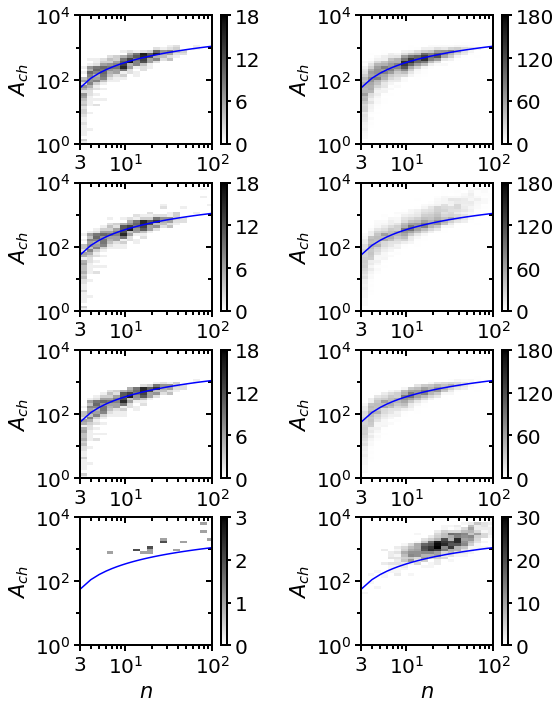

In [10]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
n = np.linspace(3, 100, 98)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y = [simulation_1, algorithm_1, post_selection_1, merged_1,
       simulation_2, algorithm_2, post_selection_2, merged_2]
vmax = [18, 18, 18, 3, 180, 180, 180, 30]
cbar_spacing = [6, 6, 6, 1, 60, 60, 60, 10]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))

for i, axis in enumerate(axeses):
    histogram.reset()
    histogram.fill(*y[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.plot(n, ch.calc_area_convex_hull_2d_pt2(8, n), "-", color="b")
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"Figures\Figure 3\2d_histograms.svg")

## Visualization of cluster merging
Top: Simulation (ground truth) - produces 3 clusters in the displayed area\
Bottom: DBScan result - produces 2 clusters in the displayed area

In [11]:
parent_intensity = 1e-5
sim_param = dict(cluster_mu=9, cluster_std=8, lower_limit=-5000, upper_limit=5000, min_samples=3, 
                 seed=np.random.default_rng(100))
alg_param = dict(eps=25, min_samples=3)
samples, coordinates_sim, coordinates_alg, merged_indices = scmerge.visualization_merging(parent_intensity, sim_param,
                                                                                          alg_param)

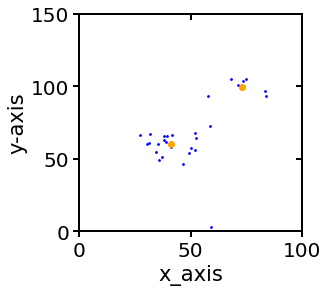

In [12]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_sim[:, 0], coordinates_sim[:, 1], color="orange")
ax.set_xlim(-1400, -1300)
ax.set_ylim(3780, 3880)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(-1399, -1301)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(3781, 3879)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure 3 supplementary\Merged_clusters_scatter_1.svg")

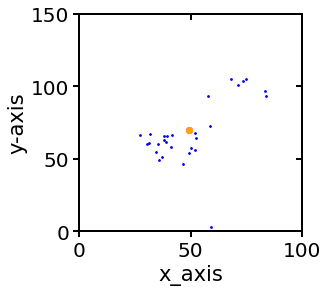

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_alg[:, 0], coordinates_alg[:, 1], color="magenta")
ax.scatter(coordinates_alg[merged_indices][:, 0], coordinates_alg[merged_indices][:, 1], color="orange")
ax.set_xlim(-1400, -1300)
ax.set_ylim(3780, 3880)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(-1399, -1301)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(3781, 3879)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure 3 supplementary\Merged_clusters_scatter_2.svg")